# Umferðargreining um Fjarðarheiði, Strákagöng og Dýrafjarðargöng 🚧

Í eftirfarandi greiningu eru umferðartölur fyrir `Seyðisfjarðarveg 93 - Fjarðarheiði` kannaðar og settar í samhengi við vegkafla aðliggjandi Strákagöngum og Dýrafjarðargöng.<br>
Umferðartölur eru fengnar á vef *Vegagerðarinnar*, https://www.vegagerdin.is/vegagerdin/gagnasafn/umferdartolur, en gögnin ná til daglegs fjölda ferða skv. umferðateljurum stofnunarinnar.

## Efnisyfirlit <a name="0_efnisyfirlit"></a>📜
[1. Forvinnsla talnagagna](#1_forvinnsla)<br>
[2. Magnvinnsla talnagagna](#2_magnvinnsla)<br>
[3. Gagnagreining](#3_gagnagreining)<br>
[4. Hagkvæmnimat út frá umferðarmagni](#4_hagkvaemnimat)<br>
[5. Slysatíðni](#5_slysatidni)<br>

[Aftur í efnisyfirlit](#0_efnisyfirlit)
## 1. Forvinnsla talnagagna<a name="1_forvinnsla"></a> 🧹

Lesum skjölin af drifinu, umferðartölurnar eru geymdar í `.txt` skrám á sama stað og þessi stílabók er vistuð undir: `./data`.<br>
Þau má nálgast hér: https://www.vegagerdin.is/vegagerdin/gagnasafn/umferdartolur/solarhringstolur-fra-umferdarteljurum

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Helper function for printing
def printUnderline(msg):
    print(msg)
    print("-"*len(msg))

# Data path
datapath = './data/'
    
# Load all *.txt files to list
files = sorted([filename for filename in os.listdir(datapath) if ".txt" in filename])
files = [datapath+filename for filename in files]

# Display what files were found
printUnderline("Fann eftirfarandi textaskrár:")
for each in files:
      print(" · "+each)

Fann eftirfarandi textaskrár:
-----------------------------
 · ./data/r_cross_umferd_2019.txt
 · ./data/r_cross_umferd_2020_fastir.txt
 · ./data/r_cross_umferd_2021_fastir.txt
 · ./data/r_cross_umferd_2022_fastir-1.txt
 · ./data/r_cross_umferd_2023_fastir.txt
 · ./data/r_cross_umferd_2024_fastir.txt


Lesum inn talnagögnin úr einni skrá, t.d. fyrir `2024` sem er þá skrá nr. `5` í listanum

In [2]:
import codecs

def parseTextFile(filename):
    # Read raw bytes first
    with open(filename, "rb") as f:
        raw = f.read()

    if raw.startswith(codecs.BOM_UTF16_LE) or raw.startswith(codecs.BOM_UTF16_BE):
        txt = raw.decode("utf-16")
    else:
        txt = raw.decode("iso-8859-1")

    return txt

txt = parseTextFile(files[5])

Fastanúmer `Seyðisfjarðarvegar 93` yfir Fjarðarheiði er `1338`. <br>
Notum `regex` með *pattern search* til að lesa út textablokkina fyrir viðkomandi `fastnr.`

In [3]:
def getSectionText(fastnr, txt):
    # \s* matches spaces, tabs, and NBSP after decoding
    pattern = rf"(fastnr\.\s*{fastnr}\b.*?)(?=fastnr\.|\Z)"
    match = re.search(pattern, txt, flags=re.S)
    return match.group(1) if match else None
    
section_text = getSectionText(fastnr="1338", txt=txt)
section_text[:750]

'fastnr. 1338  stöð 8165\r\n\r\n\r\n                Jan          Feb          Mar          Apr          Maí          Jún           Júl          Ágú          Sep          Okt          Nóv          Des\r\n   Dnr                                                                                                                                                                     Dnr\r\n\r\n     01           52    f     308    f     358            98          665   l      734         1026    f    1696    s     820    þ    1013    f     442    s      73       01\r\n     02    þ     209    f     259    l     411    þ      392   f      659   s      706    þ    1127    f    1063          892         1128    l     306          236       02\r\n     03          269    l   '

Einmitt, þetta er akkúrat **hið núll spennandi sull** sem við vorum að leita að.🫠<br>
Nú þurfum við að hreinsa þetta til og koma í töflu

In [4]:
def parseToDataFrame(section_text):
    lines = section_text.splitlines()

    # Find the header line with month names
    header_idx = next(i for i, line in enumerate(lines) if "Jan" in line and "Feb" in line and "Mar" in line)
    header = lines[header_idx]
    dnr_line = lines[header_idx + 1]   # line that has 'Dnr' at left and right

    # Month labels exactly as in the header
    month_labels_file = ["Jan", "Feb", "Mar", "Apr", "Maí", "Jún",
                         "Júl", "Ágú", "Sep", "Okt", "Nóv", "Des"]

    # Start positions for each month label
    month_starts = [header.index(m) for m in month_labels_file]

    # Start position of the right-hand "Dnr" (use rindex to get the last one)
    right_dnr_start = dnr_line.rindex("Dnr")

    # End position for each month = start of next column; for Dec, use right Dnr
    month_ends = month_starts[1:] + [right_dnr_start]

    rows = []

    # Parse daily rows
    for line in lines[header_idx + 2:]:
        m_day = re.match(r"\s*(\d{2})\s", line)
        if not m_day:
            continue

        day = int(m_day.group(1))
        vals = []

        # Slice each month column using the fixed-width ranges
        for s, e in zip(month_starts, month_ends):
            field = line[s:e]
            m_val = re.search(r"\d+", field)
            vals.append(int(m_val.group()) if m_val else None)

        rows.append([day] + vals)

    # Build DataFrame, with day as index
    month_labels_df = ["jan","feb","mar","apr","may","jun",
                       "jul","aug","sep","oct","nov","dec"]

    df = pd.DataFrame(rows, columns=["day"] + month_labels_df)
    df = df.set_index("day").sort_index()

    return df

df = parseToDataFrame(section_text)

🎁 Kíkjum í pakkann!

In [5]:
df 

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
day,,,,,,,,,,,,
1,52,308.0,358,98.0,665,734.0,1026,1696,820.0,1013,442.0,73
2,209,259.0,411,392.0,659,706.0,1127,1063,892.0,1128,306.0,236
3,269,248.0,341,682.0,516,561.0,1205,1056,1064.0,783,288.0,196
4,274,370.0,316,567.0,789,176.0,1544,964,1296.0,721,465.0,352
5,310,271.0,458,396.0,534,237.0,1032,967,1456.0,635,543.0,127
6,310,212.0,449,138.0,616,962.0,827,1266,1167.0,514,480.0,244
7,284,298.0,413,0.0,931,777.0,935,1380,995.0,649,435.0,170
8,222,368.0,453,96.0,847,738.0,1152,1708,896.0,745,434.0,185
9,296,332.0,370,617.0,581,676.0,1185,1191,988.0,809,428.0,299


🧊 Ókei bræðum þennan klump núna í eina langa tímaröð...

In [6]:
def gridToSeries(df, year):
    df_long = df.reset_index().melt(id_vars="day", var_name="month", value_name="traffic")

    month_map = {   "jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,
                    "jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12   }

    df_long["month_num"] = df_long["month"].map(month_map) 
    df_long["date"] = pd.to_datetime(dict(year=year, month=df_long["month_num"], day=df_long["day"]), errors="coerce")  # invalid combos (e.g., Feb 30) -> NaT

    df_long = df_long.dropna()
    df_long["traffic"] = pd.to_numeric(df_long["traffic"], errors="coerce")

    return df_long
year = 2023
df_long = gridToSeries(df, year)

In [7]:
df_long

,day,month,traffic,month_num,date
0,1,jan,52.0,1,2023-01-01
1,2,jan,209.0,1,2023-01-02
2,3,jan,269.0,1,2023-01-03
3,4,jan,274.0,1,2023-01-04
4,5,jan,310.0,1,2023-01-05
...,...,...,...,...,...
367,27,dec,282.0,12,2023-12-27
368,28,dec,234.0,12,2023-12-28
369,29,dec,231.0,12,2023-12-29
370,30,dec,341.0,12,2023-12-30


📈 Sjáum nú hvernig þessi tímaröð lítur út á grafi 📉

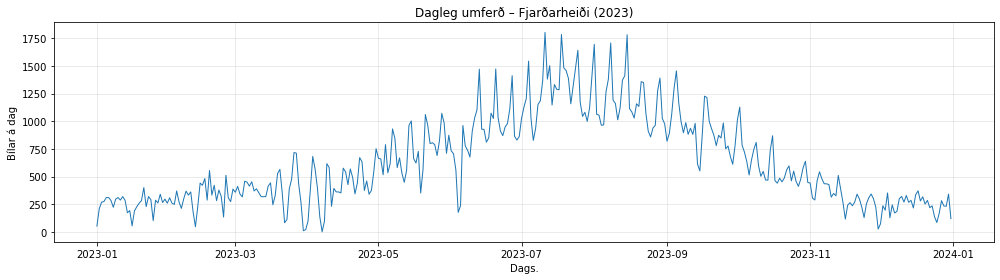

In [8]:
plt.figure(figsize=(14,4))
plt.plot(df_long["date"], df_long["traffic"], marker="", linewidth=1)
plt.title(f"Dagleg umferð – Fjarðarheiði ({year})")
plt.xlabel("Dags.")
plt.ylabel("Bílar á dag")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[Aftur í efnisyfirlit](#0_efnisyfirlit)
## 2. Magnvinnsla talnagagna<a name="2_magnvinnsla"></a> 🏭

Jæja, við erum búin að búa til aðferðirnar til að vinna á þessu **sulli** af gögnum frá Vegagerðinni. <br>
Nú er að gyrða sig í brók og lesa þessi gögn inn fyrir:

**2019 ... 2024**

Veg með fastanúmeri (fastnr. `1338`) - Fjarðarheiði (Seyðisfjarðarvegur 93)<br>
Veg með fastanúmeri (fastnr. `1323`) - Siglufjarðarvegur við Almenningsnöf<br>
Veg með fastanúmeri (fastnr. `5599`) - Vestfjarðarvegur rétt norðan Dýrafjarðargangna, akrein N <br>
Veg með fastanúmeri (fastnr. `5600`) - Vestfjarðarvegur rétt norðan Dýrafjarðargangna, akrein S


In [9]:
years = [year for year in range(2019,2025)]
txts = [parseTextFile(file) for file in files]
sections_fjardarheidi = [getSectionText("1338",txt) for txt in txts]
sections_strakagong = [getSectionText("1323",txt) for txt in txts]
sections_dyrafjardargong_N = [getSectionText("5599",txt) for txt in txts]
sections_dyrafjardargong_S = [getSectionText("5600",txt) for txt in txts]
sections = [sections_fjardarheidi, sections_strakagong,sections_dyrafjardargong_N, sections_dyrafjardargong_S]

fjardarheidi = {}
strakagong = {}
dyrafjardargong_N = {}
dyrafjardargong_S = {}

dicts = [fjardarheidi, strakagong, dyrafjardargong_N, dyrafjardargong_S]

for sec, dic in zip(sections, dicts):
    for year, sec in zip(years,sec):
        try:
            df = parseToDataFrame(sec)
            dic[year] = {'grid':df,'series':gridToSeries(df,year)}
        except:
            pass

In [10]:
def combine_two_lanes(series_N, series_S):

    df = (series_N[["date", "traffic"]]
          .merge(series_S[["date", "traffic"]], 
                 on="date",how="outer",suffixes=("_N", "_S")))

    df["traffic"] = ( df["traffic_N"] +df["traffic_S"])

    df = df[["date", "traffic"]].sort_values("date")

    return df

In [11]:
dyrafjardargong = {}

for year in years:
    if year not in dyrafjardargong_N or year not in dyrafjardargong_S:
        continue

    series_combined = combine_two_lanes( dyrafjardargong_N[year]["series"],
                                        dyrafjardargong_S[year]["series"])

    dyrafjardargong[year] = {"series": series_combined}

Æði, nú eigum við `dictionary` þar sem við getum `key`-að okkur niður á `year` og gerð af `DataFrame`, þ.e. `grid` tvívítt form eða `series` tímaröð. <br>
Sem dæmi:

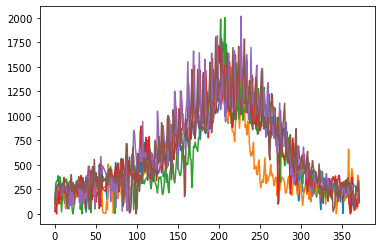

In [12]:
plt.figure()
for year in years:
    try:
        fjardarheidi[year]['series']['traffic'].plot()
    except:
        continue

plt.show()

[Aftur í efnisyfirlit](#0_efnisyfirlit)
## 3. Gagnagreining <a name="3_gagnagreining"></a> 🔬

Nú förum við aðeins að rýna í tölurnar sjálfar á myndrænan og skemmtilegan hátt.

Við skulum teikna upp graf af daglegum umferðartölum yfir Fjarðarheiði og um Strákagöng.

In [13]:
def plotSeries(df_series, label=None, lw=1, alpha=1.0):
    if "date" not in df_series or "traffic" not in df_series:
        raise ValueError("df_series must contain 'date' and 'traffic' columns")

    plt.plot(df_series["date"],
             df_series["traffic"],
             linewidth=lw,
             alpha=alpha,
             label=label,)

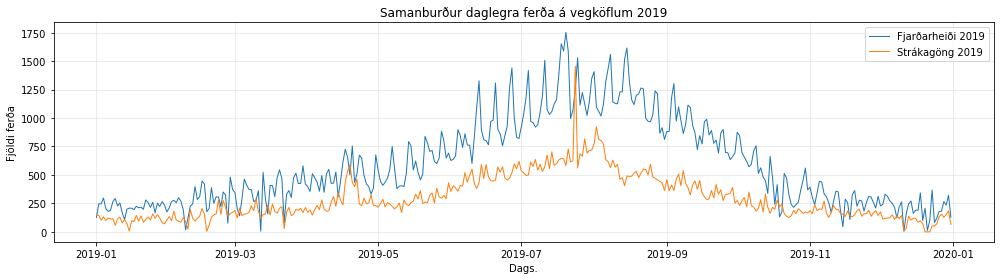

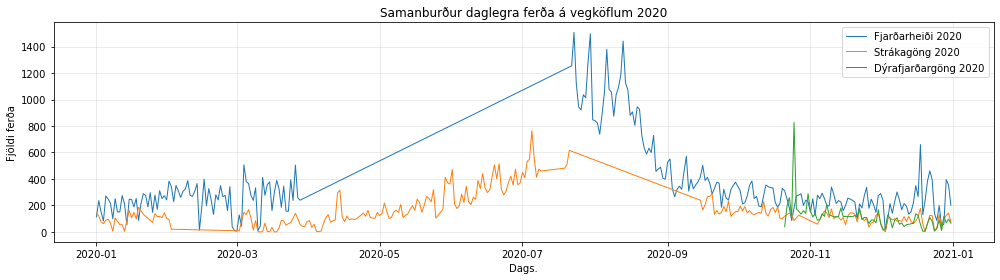

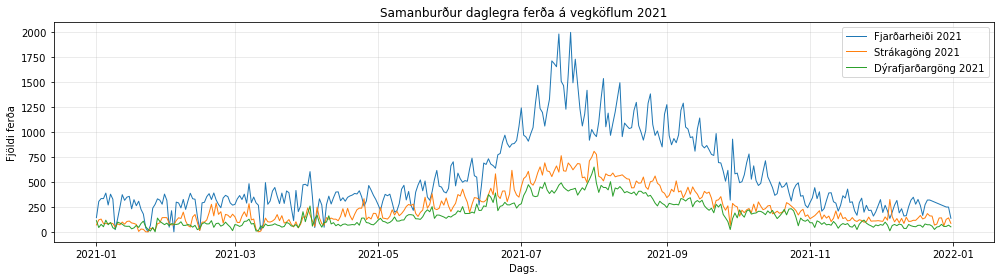

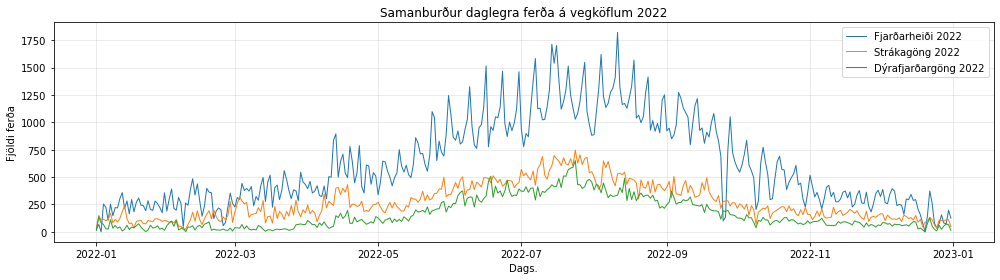

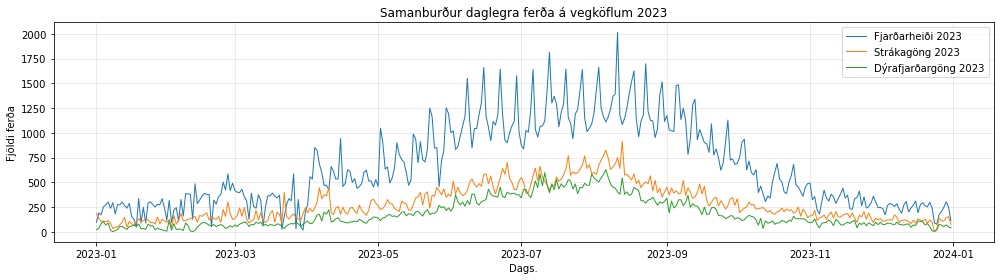

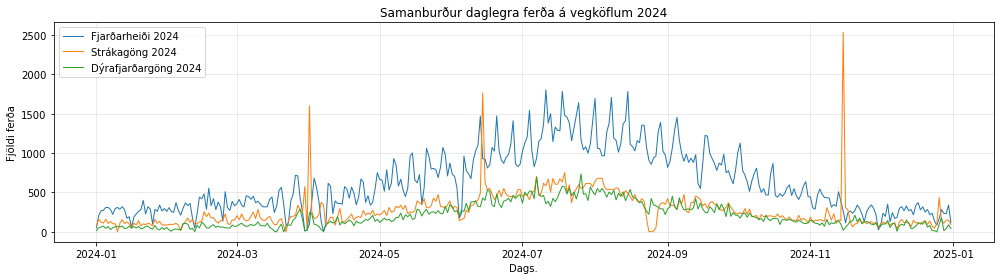

In [14]:
for year in years:
    plt.figure(figsize=(14,4))

    plotSeries(fjardarheidi[year]['series'], label=f"Fjarðarheiði {year}")
    plotSeries(strakagong[year]['series'], label=f"Strákagöng {year}")
    try:
        plotSeries(dyrafjardargong[year]['series'], label=f"Dýrafjarðargöng {year}")
    except:
        pass
    plt.title(f"Samanburður daglegra ferða á vegköflum {year}")
    plt.xlabel("Dags.")
    plt.ylabel("Fjöldi ferða")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

🤨 Það eru stórfurðulegir umferðatoppar í tölunum um Strákagöng frá 2024! <br>
Köfum aðeins dýpra í það...<br>

### 3.1 Rannsókn á útlögum í gagnasafni
Ég ætla að kanna umferð á nærliggjandi vegi á svæðinu, um Hólshyrnu.<br>
Umferðateljarinn við Hólshyrnu er með fastnr. `5601`.

In [15]:
section_holshyrna = [getSectionText("5601",txt) for txt in txts]

holshyrna = {}

for year,sec in zip(years, section_holshyrna ):
    if sec is None:
        continue
    df = parseToDataFrame(sec)
    holshyrna[year] = {'grid':df,'series':gridToSeries(df,year)}

<AxesSubplot:xlabel='day'>

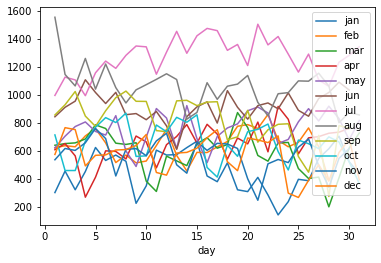

In [16]:
holshyrna[2021]['grid'].plot()

Birtum nú sólarhringsferðir aftur og sjáum hvort samhengi sé í ferðum um Almenningsnöf og Hólshyrnu árið 2024.

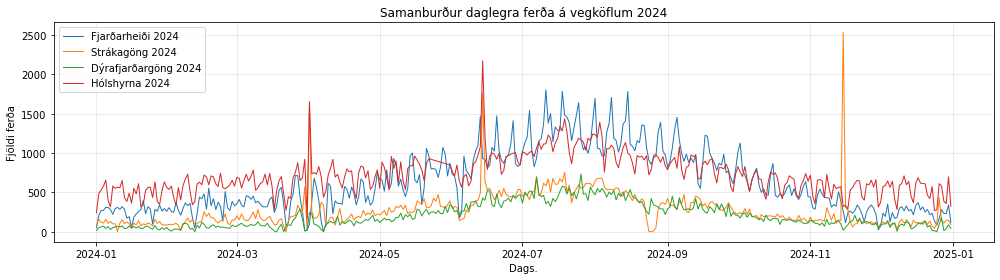

In [17]:
year = 2024
plt.figure(figsize=(14,4))

plotSeries(fjardarheidi[year]['series'], label=f"Fjarðarheiði {year}")
plotSeries(strakagong[year]['series'], label=f"Strákagöng {year}")
try:
    plotSeries(dyrafjardargong[year]['series'], label=f"Dýrafjarðargöng {year}")
    plotSeries(holshyrna[year]['series'], label=f"Hólshyrna {year}")
except:
    pass
plt.title(f"Samanburður daglegra ferða á vegköflum {year}")
plt.xlabel("Dags.")
plt.ylabel("Fjöldi ferða")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

**TVO** af þessum **ÞREMUR** dögum, 2024, virðist umferðin um Almenningsnöf fylgja umferðatoppum um Hólshyrnu, en ekki daginn í nóvember 2024... hvað veldur?

Þetta virðist vera einangraður atburður. <br>
Voru vegaframkvæmdir eða viðhald á veginum í gangi og ítrekaðar ferðir um teljarann? <br>
Ef Öxnadalsheiðin var lokuð ætti að sjást toppur á teljaranum við Hólshyrnu líka.<br>
Hvað er í gangi þarna?

### 3.2 Meðaltöl

Tökum næst saman mánaðarleg og árleg meðaltöl umferðar. <br>
Til þess þarf nokkra undirbúningsvinnu.

In [18]:
def dict_to_long(df_dict, road_name):
    frames = []

    for year, parts in df_dict.items():
        if "series" not in parts:
            continue

        df = parts["series"].copy()

        if "traffic" not in df.columns:
            continue
            
        df["traffic"] = pd.to_numeric(df["traffic"], errors="coerce")

        if "date" in df.columns:
            df["date"] = pd.to_datetime(df["date"], errors="coerce")
            df = df.dropna(subset=["date", "traffic"])

            df["day"] = df["date"].dt.day
            df["month_num"] = df["date"].dt.month
            
        else:
            if "month_num" not in df.columns:
                if "month" in df.columns:
                    df["month_num"] = df["month"]
                else:
                    continue

            if "day" not in df.columns:
                if df.index.name == "day":
                    df = df.reset_index()
                else:
                    continue

            df["day"] = pd.to_numeric(df["day"], errors="coerce")
            df["month_num"] = pd.to_numeric(df["month_num"], errors="coerce")

            df["date"] = pd.to_datetime(
                dict(year=year, month=df["month_num"], day=df["day"]),
                errors="coerce"
            )

            df = df.dropna(subset=["date", "traffic"])

        df["year"] = year
        df["road"] = road_name

        frames.append(df[["date", "traffic", "year", "road", "day", "month_num"]])

    if not frames:
        return pd.DataFrame(columns=["date", "traffic", "year", "road", "day", "month_num"])

    return pd.concat(frames, ignore_index=True)


Búum til `dict` fyrir hvern vegkafla sem inniheldur tímaröð og splæsum saman í eitt `DataFrame`

In [19]:
# build combined DF for all roads
df_fj = dict_to_long(fjardarheidi, "Fjarðarheiði")
df_st = dict_to_long(strakagong, "Strákagöng")
df_df = dict_to_long(dyrafjardargong, "Dýrafjarðargöng")

df_all = pd.concat([df_fj, df_st, df_df], ignore_index=True)
df_all["month"] = df_all["date"].dt.month

In [20]:
df_all

,date,traffic,year,road,day,month_num,month
0,2019-01-01,126.0,2019,Fjarðarheiði,1,1,1
1,2019-01-02,247.0,2019,Fjarðarheiði,2,1,1
2,2019-01-03,245.0,2019,Fjarðarheiði,3,1,1
3,2019-01-04,298.0,2019,Fjarðarheiði,4,1,1
4,2019-01-05,204.0,2019,Fjarðarheiði,5,1,1
...,...,...,...,...,...,...,...
5675,2024-12-27,180.0,2024,Dýrafjarðargöng,27,12,12
5676,2024-12-28,16.0,2024,Dýrafjarðargöng,28,12,12
5677,2024-12-29,39.0,2024,Dýrafjarðargöng,29,12,12
5678,2024-12-30,90.0,2024,Dýrafjarðargöng,30,12,12


In [21]:
df_all[df_all['road']=='Dýrafjarðargöng'].head()

,date,traffic,year,road,day,month_num,month
4147,2020-10-21,39.0,2020,Dýrafjarðargöng,21,10,10
4148,2020-10-22,195.0,2020,Dýrafjarðargöng,22,10,10
4149,2020-10-23,259.0,2020,Dýrafjarðargöng,23,10,10
4150,2020-10-24,116.0,2020,Dýrafjarðargöng,24,10,10
4151,2020-10-25,827.0,2020,Dýrafjarðargöng,25,10,10


Sjáum að fyrir `Dýrafjarðargöng` er tímaröðin gloppótt þar sem þau opnuðu 25. september 2020 og umferðateljarinn virðist hafa verið gangsettur 21. september sama ár.
Bætum við dagsetningunum sem vantar svo tímaröðin sé fullskipuð og fillum með `NaN` (*not-a-number*).

In [22]:
full_dates = pd.date_range("2019-01-01", "2024-12-31", freq="D")

df_all = (df_all.groupby(["road","date"], as_index=False)["traffic"].sum())

def expand_one_road(d):
    road = d["road"].iloc[0]
    out = (d.set_index("date")
             .reindex(full_dates)
             .rename_axis("date")
             .reset_index())
    out["road"] = road
    out["year"] = out["date"].dt.year
    out["month_num"] = out["date"].dt.month
    out["day"] = out["date"].dt.day
    return out

df_all = df_all.groupby("road", group_keys=False).apply(expand_one_road)

In [23]:
df_all.groupby(["road","year"]).count()

date  traffic  month_num  day
road            year                               
Dýrafjarðargöng 2019   365        0        365  365
                2020   366       72        366  366
                2021   365      365        365  365
                2022   365      365        365  365
                2023   365      365        365  365
                2024   366      366        366  366
Fjarðarheiði    2019   365      365        365  365
                2020   366      251        366  366
                2021   365      359        365  365
                2022   365      365        365  365
                2023   365      365        365  365
                2024   366      366        366  366
Strákagöng      2019   365      362        365  365
                2020   366      257        366  366
                2021   365      365        365  365
                2022   365      365        365  365
                2023   365      361        365  365
                2024   366      366        366  366

In [24]:
df_all.groupby(['year','road']).max()

date  traffic  month_num  day
year road                                               
2019 Dýrafjarðargöng 2019-12-31      NaN         12   31
     Fjarðarheiði    2019-12-31   1753.0         12   31
     Strákagöng      2019-12-31   1455.0         12   31
2020 Dýrafjarðargöng 2020-12-31    827.0         12   31
     Fjarðarheiði    2020-12-31   1508.0         12   31
     Strákagöng      2020-12-31    765.0         12   31
2021 Dýrafjarðargöng 2021-12-31    650.0         12   31
     Fjarðarheiði    2021-12-31   2001.0         12   31
     Strákagöng      2021-12-31    808.0         12   31
2022 Dýrafjarðargöng 2022-12-31    651.0         12   31
     Fjarðarheiði    2022-12-31   1822.0         12   31
     Strákagöng      2022-12-31    747.0         12   31
2023 Dýrafjarðargöng 2023-12-31    629.0         12   31
     Fjarðarheiði    2023-12-31   2015.0         12   31
     Strákagöng      2023-12-31    913.0         12   31
2024 Dýrafjarðargöng 2024-12-31    736.0         12   31
     Fjarðarheiði    2024-12-31   1804.0         12   31
     Strákagöng      2024-12-31   2535.0         12   31

In [25]:
df_all.groupby(["road"]).count()

,date,traffic,year,month_num,day
road,,,,,
Dýrafjarðargöng,2192,1533,2192,2192,2192
Fjarðarheiði,2192,2071,2192,2192,2192
Strákagöng,2192,2076,2192,2192,2192


### 3.3 Meðaltöl - gröf
Jæja, þá erum við loks í stakk búin til að skoða daglega meðalumferð á ársgrundvelli...

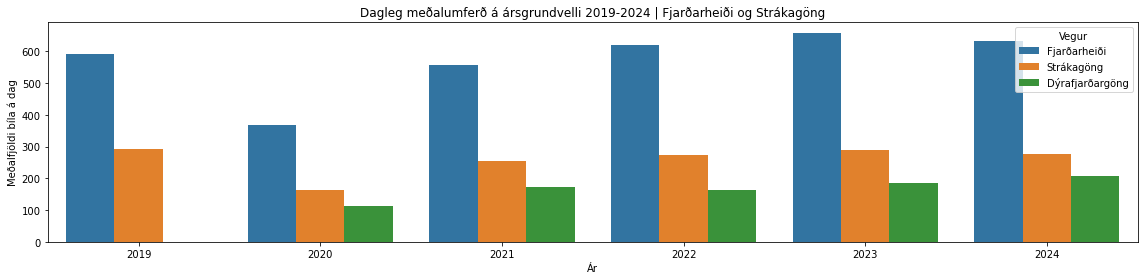

In [26]:
yearly = (df_all.groupby(["road", "year"])["traffic"].mean().reset_index().sort_values("traffic", ascending=False))

plt.figure(figsize=(16,4))
sns.barplot(data=yearly, x="year", y="traffic", hue="road")
plt.title("Dagleg meðalumferð á ársgrundvelli 2019-2024 | Fjarðarheiði og Strákagöng")
plt.legend(title='Vegur')
plt.ylabel("Meðalfjöldi bíla á dag")
plt.xlabel("Ár")
plt.tight_layout()
plt.show()

... og á mánaðargrundvelli, öll árin á sama grafi

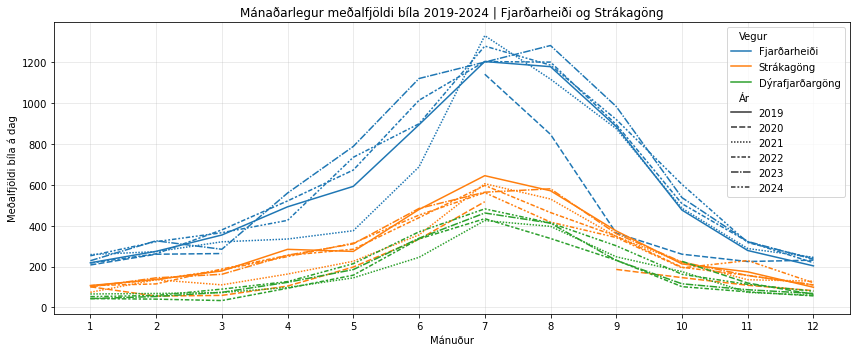

In [27]:
monthly = (df_all.groupby(["road", "year", "month_num"])["traffic"].mean().reset_index().sort_values("traffic", ascending=False))

plt.figure(figsize=(12,5))
sns.lineplot(data=monthly,    
             x="month_num",    
             y="traffic",    
             hue="road",    
             style="year",   # separate line per year+road; remove if too busy    
             markers=False,)

plt.xticks(range(1,13))
plt.xlabel("Mánuður")
plt.ylabel("Meðalfjöldi bíla á dag")
plt.title("Mánaðarlegur meðalfjöldi bíla 2019-2024 | Fjarðarheiði og Strákagöng")
ax = plt.gca()
leg = ax.get_legend()

for text in leg.get_texts():
    if text.get_text() == "road":
        text.set_text("Vegur")
    elif text.get_text() == "year":
        text.set_text("Ár")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Við getum líka skoðað þau mánuð fyrir mánuð:

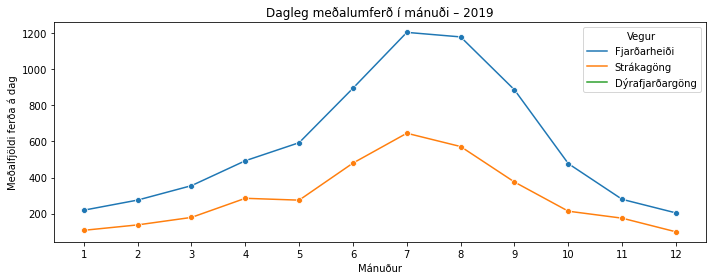

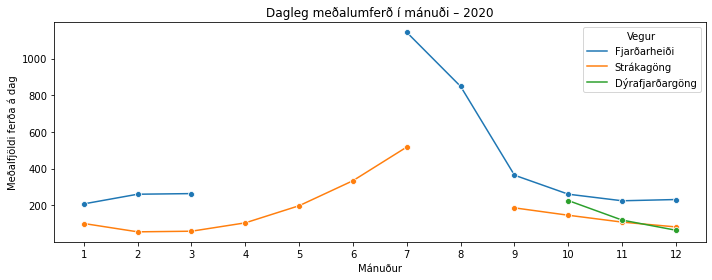

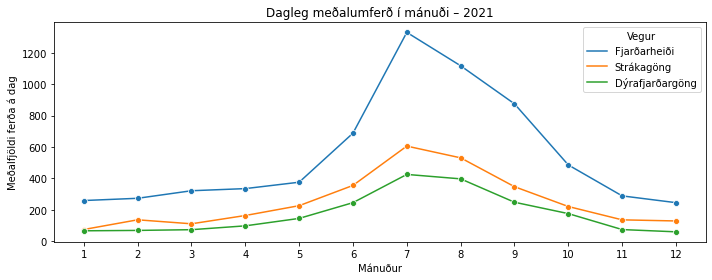

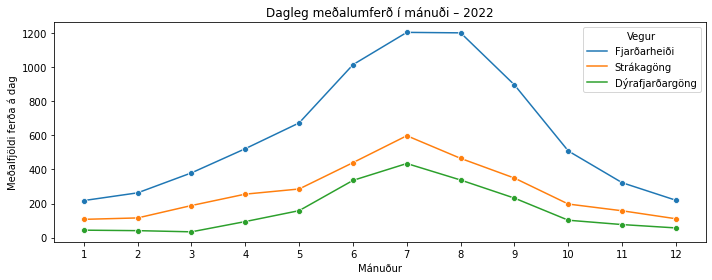

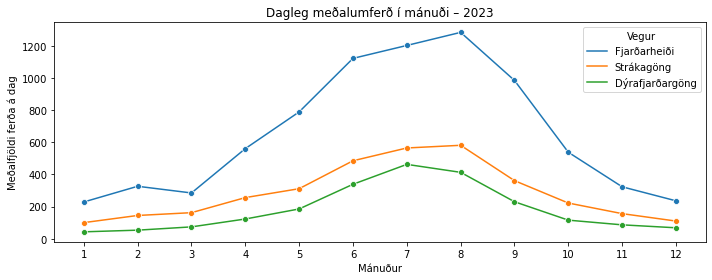

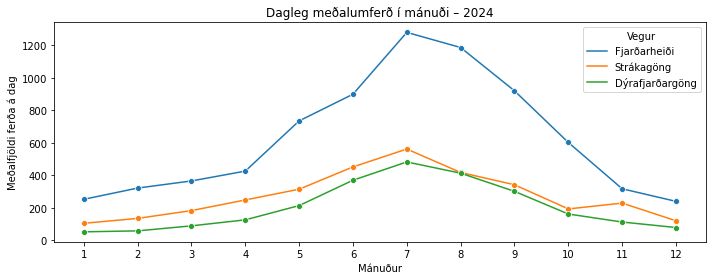

In [28]:
def plot_monthly(monthly):
    plt.figure(figsize=(10,4))
    sns.lineplot(data=monthly_per_year,
                 x="month_num",
                 y="traffic",
                 hue="road",
                 marker="o",)
    plt.xlabel("Mánuður")
    plt.ylabel("Meðalfjöldi ferða á dag")
    plt.legend(title="Vegur")
    plt.xticks(range(1,13))
    plt.title(f"Dagleg meðalumferð í mánuði – {year}")
    plt.tight_layout()
    plt.show()

for year in years:
    monthly_per_year = monthly[monthly["year"] == year]
    plot_monthly(monthly_per_year)

Sjáum þarna að teljarar í `Strákagöngum` og á `Fjarðarheiði` eru úti stóran hluta árs 2020:

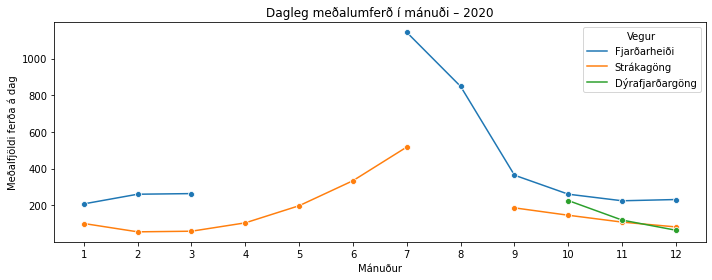

In [29]:
year=2020
monthly_per_year = monthly[monthly["year"] == year]
plot_monthly(monthly_per_year)

### 3.4 Summur
Tökum saman heildarfjölda ferða

In [30]:
total_trips = (df_all.groupby("road")["traffic"].sum().reset_index().sort_values("traffic", ascending=False))
total_trips

,road,traffic
1,Fjarðarheiði,1205327.0
2,Strákagöng,546368.0
0,Dýrafjarðargöng,273817.0


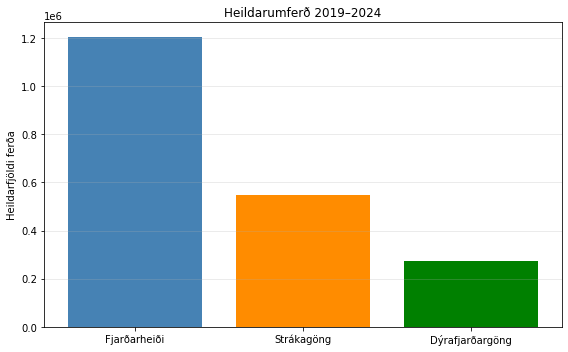

In [31]:
plt.figure(figsize=(8,5))
plt.bar(total_trips["road"], total_trips["traffic"], color=["steelblue", "darkorange", "green"])
plt.ylabel("Heildarfjöldi ferða")
plt.title("Heildarumferð 2019–2024")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Réttara væri að bera hann saman á jafnræðisgrundvelli, það vantar auðvitað stóran hluta árs 2020 á Fjarðarheiði, í Strákagöngum og þá voru Dýrafjarðargöng tekin í notkun í október 2020. 

‼️ Skoðum tölfræðina **frá 2021**.

In [32]:
total_trips_21_24=df_all[df_all["year"]>2020].groupby("road")["traffic"].sum().reset_index().sort_values("traffic", ascending=False)

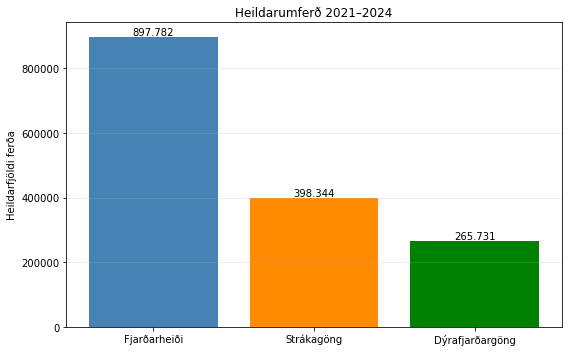

In [33]:
plt.figure(figsize=(8,5))

bars = plt.bar(total_trips_21_24["road"],total_trips_21_24["traffic"],color=["steelblue", "darkorange", "green"])

plt.ylabel("Heildarfjöldi ferða")
plt.title("Heildarumferð 2021–2024")
plt.grid(axis="y", alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,height,f"{int(height):,}".replace(",", "."),ha="center",va="bottom",fontsize=10)

plt.tight_layout()
plt.show()

In [34]:
f = total_trips_21_24.loc[total_trips_21_24["road"] == "Fjarðarheiði","traffic"].iloc[0]
s = total_trips_21_24.loc[total_trips_21_24["road"] == "Strákagöng","traffic"].iloc[0]
d = total_trips_21_24.loc[total_trips_21_24["road"] == "Dýrafjarðargöng","traffic"].iloc[0]

factor_f_s = f / s
factor_f_d = f / d

printUnderline('Hversu margfalt voru ferðir um Fjarðarheiði en Strákagöng?')
print(f'x{factor_f_s:.2f}\n')
printUnderline('Hversu margfalt fleiri voru ferðir um Fjarðarheiði en Dýrafjarðargöng?')
print(f'x{factor_f_d:.2f}')

Hversu margfalt voru ferðir um Fjarðarheiði en Strákagöng?
----------------------------------------------------------
x2.25

Hversu margfalt fleiri voru ferðir um Fjarðarheiði en Dýrafjarðargöng?
----------------------------------------------------------------------
x3.38


In [35]:
yearly_totals = (df_all.groupby(["year", "road"])["traffic"].sum().reset_index())

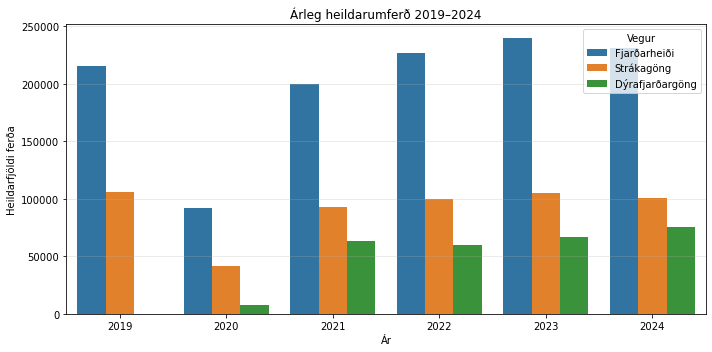

In [36]:
def plot_yearly_totals(df, title):
    plt.figure(figsize=(10,5))
    sns.barplot(data=df.sort_values("traffic",ascending=False),x="year",y="traffic",hue="road")
    plt.xlabel("Ár")
    plt.ylabel("Heildarfjöldi ferða")
    plt.title(title)
    plt.grid(axis="y", alpha=0.3)
    plt.legend(title='Vegur')
    plt.tight_layout()
    plt.show()
plot_yearly_totals(yearly_totals, "Árleg heildarumferð 2019–2024")

Skoðum þá líka aðeins frá `2021`

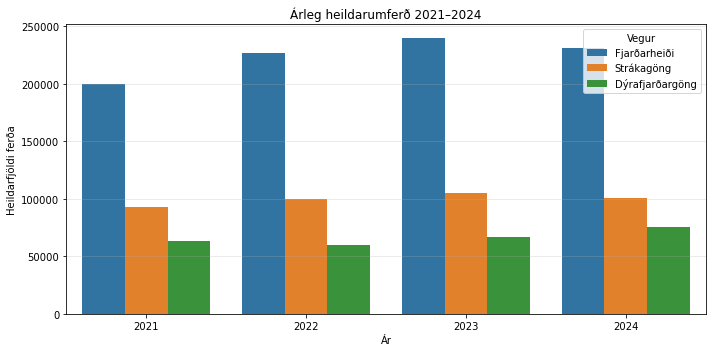

In [37]:
yearly_totals_21_24 = (df_all[df_all['year']>2020].groupby(["year", "road"])["traffic"].sum().reset_index())
plot_yearly_totals(yearly_totals_21_24, "Árleg heildarumferð 2021–2024")

### 3.5 Tölfræðisamanburður

Skoðum hlutfall daga þar sem umferðarmagn um `Fjarðarheiði` er meira en um `Dýrafjarðargöng` annarsvegar og `Strákagöng` hinsvegar.

Notum árabilið `2021-2024` fyrir hreinan og sanngjarnan samanburð af áðurgreindum ástæðum.

In [38]:
pivot = yearly_totals_21_24.pivot(index="year",columns="road",values="traffic")

In [39]:
pivot

road,Dýrafjarðargöng,Fjarðarheiði,Strákagöng
year,,,
2021,63539.0,200102.0,92777.0
2022,59495.0,226526.0,99789.0
2023,67190.0,240229.0,104695.0
2024,75507.0,230925.0,101083.0


In [40]:
df_all_21_24 = df_all[df_all['year']>2020]

In [41]:
daily = (df_all_21_24.pivot_table(index="date", columns="road", values="traffic", aggfunc="mean").dropna())
daily["dF-S"] = daily["Fjarðarheiði"] - daily["Strákagöng"]
daily["dF-D"] = daily["Fjarðarheiði"] - daily["Dýrafjarðargöng"]

In [42]:
daily.head()

road,Dýrafjarðargöng,Fjarðarheiði,Strákagöng,dF-S,dF-D
date,,,,,
2021-01-01,112.0,143.0,69.0,74.0,31.0
2021-01-02,43.0,305.0,120.0,185.0,262.0
2021-01-03,75.0,334.0,128.0,206.0,259.0
2021-01-04,51.0,333.0,83.0,250.0,282.0
2021-01-05,117.0,389.0,83.0,306.0,272.0


In [43]:
daily["dF-D"].describe()

count    1451.000000
mean      435.141282
std       289.335069
min      -149.000000
25%       224.000000
50%       350.000000
75%       611.500000
max      1611.000000
Name: dF-D, dtype: float64

In [44]:
daily["dF-S"].describe()

count    1451.000000
mean      343.756720
std       287.399889
min     -2270.000000
25%       157.000000
50%       267.000000
75%       509.000000
max      1394.000000
Name: dF-S, dtype: float64

In [45]:
prob = (daily["dF-S"] > 0).mean()
mean_diff = daily["dF-S"].mean()
median_diff = daily["dF-S"].median()

printUnderline('Fjarðarheiði - Strákagöng')
print(f"P(Fjarðarheiði > Strákagöng) = {prob:.3f}")
print(f"Mean daily diff = {mean_diff:.1f}")
print(f"Median daily diff = {median_diff:.1f}")

prob = (daily["dF-D"] > 0).mean()
mean_diff = daily["dF-D"].mean()
median_diff = daily["dF-D"].median()

printUnderline('Fjarðarheiði - Dýrafjarðargöng')
print(f"P(Fjarðarheiði > Dýrafjarðargöng) = {prob:.3f}")
print(f"Mean daily diff = {mean_diff:.1f}")
print(f"Median daily diff = {median_diff:.1f}")

Fjarðarheiði - Strákagöng
-------------------------
P(Fjarðarheiði > Strákagöng) = 0.959
Mean daily diff = 343.8
Median daily diff = 267.0
Fjarðarheiði - Dýrafjarðargöng
------------------------------
P(Fjarðarheiði > Dýrafjarðargöng) = 0.980
Mean daily diff = 435.1
Median daily diff = 350.0


In [46]:
daily["year"] = daily.index.year

yearly_prob_F_S = daily.groupby("year")["dF-S"].apply(lambda x: (x > 0).mean())
yearly_prob_F_D = daily.groupby("year")["dF-D"].apply(lambda x: (x > 0).mean())
printUnderline("Hlutfall daga á ári sem var meiri umferð um Fjarðarheiði en um Strákagöng")
print(yearly_prob_F_S)
print()
printUnderline("Hlutfall daga á ári sem var meiri umferð um Fjarðarheiði en um Dýrafjarðargöng")
print(yearly_prob_F_D)

Hlutfall daga á ári sem var meiri umferð um Fjarðarheiði en um Strákagöng
-------------------------------------------------------------------------
year
2021    0.966574
2022    0.956164
2023    0.961219
2024    0.950820
Name: dF-S, dtype: float64

Hlutfall daga á ári sem var meiri umferð um Fjarðarheiði en um Dýrafjarðargöng
------------------------------------------------------------------------------
year
2021    0.974930
2022    0.986301
2023    0.980609
2024    0.978142
Name: dF-D, dtype: float64


In [47]:
daily["month"] = daily.index.month
monthly_prob = daily.groupby("month")["dF-S"].apply(lambda x: (x > 0).mean())
printUnderline("Líkur á að dagleg umferð sé meiri um Fjarðarheiði en Strákagöng reiknað á mánuði ársins")
print(monthly_prob)

Líkur á að dagleg umferð sé meiri um Fjarðarheiði en Strákagöng reiknað á mánuði ársins
---------------------------------------------------------------------------------------
month
1     0.903226
2     0.919643
3     0.911290
4     0.933333
5     0.983871
6     0.983333
7     1.000000
8     1.000000
9     0.983333
10    1.000000
11    0.950000
12    0.932203
Name: dF-S, dtype: float64


In [48]:
daily["month"] = daily.index.month
monthly_prob = daily.groupby("month")["dF-D"].apply(lambda x: (x > 0).mean())
printUnderline("Líkur á að dagleg umferð sé meiri um Fjarðarheiði en Dýrafjarðargöng reiknað á mánuði ársins")
print(monthly_prob)

Líkur á að dagleg umferð sé meiri um Fjarðarheiði en Dýrafjarðargöng reiknað á mánuði ársins
--------------------------------------------------------------------------------------------
month
1     0.951613
2     0.964286
3     0.935484
4     0.966667
5     1.000000
6     0.983333
7     1.000000
8     1.000000
9     0.983333
10    1.000000
11    0.991667
12    0.983051
Name: dF-D, dtype: float64


### 3.6 Niðurstaða umferðarmagns 

$95.9\%$ daga er meiri umferð um `Fjarðarheiði` en um `Strákagöng`<br>
Að meðaltali fara $343.8$ **fleiri** bílar daglega yfir `Fjarðarheiði` en um `Strákagöng`<br>
Á hefðbundnum degi (miðgildi mismunar umferðarmagns) fara $267$ fleiri bílar um `Fjarðarheiði` en um `Strákagöng`.

$98.0\%$ daga er meiri umferð um `Fjarðarheiði` en um `Dýrafjarðargöng` <br>
Að meðaltali fara $435.1$ **fleiri** bílar daglega yfir `Fjarðarheiði` en um `Dýrafjarðargöng` <br>
Á hefðbundnum degi (miðgildi mismunar umferðarmagns) fara $350$ fleiri bílar um `Fjarðarheiði` en um `Dýrafjarðargöng`.

Munurinn er stöðugur milli ára.<br>
Munurinn er afgerandi óháð árstíð.

### 3.7 Dreifing umferðarmagns
Skoðum hvernig umferðarmagn dreifist á vegina þrjá með stuðlariti (e. histogram)

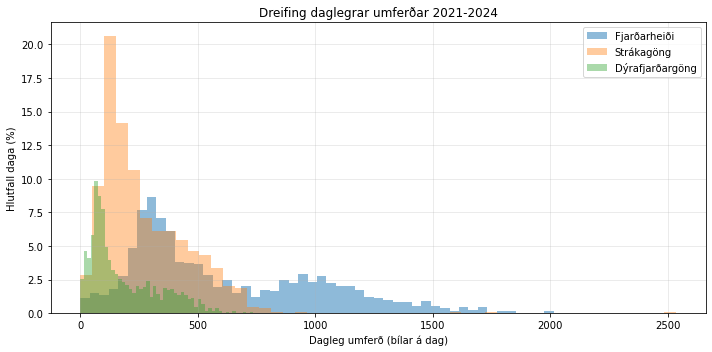

In [49]:
def percent_weights(x):
    return np.ones_like(x) / len(x) * 100

plt.figure(figsize=(10,5))

bins = 50

plt.hist(daily["Fjarðarheiði"],bins=bins,weights=percent_weights(daily["Fjarðarheiði"]),alpha=0.5,label="Fjarðarheiði")
plt.hist(daily["Strákagöng"],bins=bins,weights=percent_weights(daily["Strákagöng"]),alpha=0.4,label="Strákagöng")
plt.hist(daily["Dýrafjarðargöng"],bins=bins,weights=percent_weights(daily["Dýrafjarðargöng"]),alpha=0.4,label="Dýrafjarðargöng")

plt.xlabel("Dagleg umferð (bílar á dag)")
plt.ylabel("Hlutfall daga (%)")
plt.title("Dreifing daglegrar umferðar 2021-2024")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()



Það er greinilegt að umferðarmagn yfir `Fjarðarheiði` er tvítoppa, sem skýrist líklega af breytingum í sumar- og vetrarumferð vegna ferjusiglinga Norrænu til Seyðisfjarðar.
Við ættum að skoða hvað dreifing umferðarmagns yfir `Fjarðarheiði` er mörgum staðalfrávikum frá dreifingunni um `Strákagöng` og `Dýrafjarðargöng`.

Við getum líka borið það saman á fiðlugrafi:

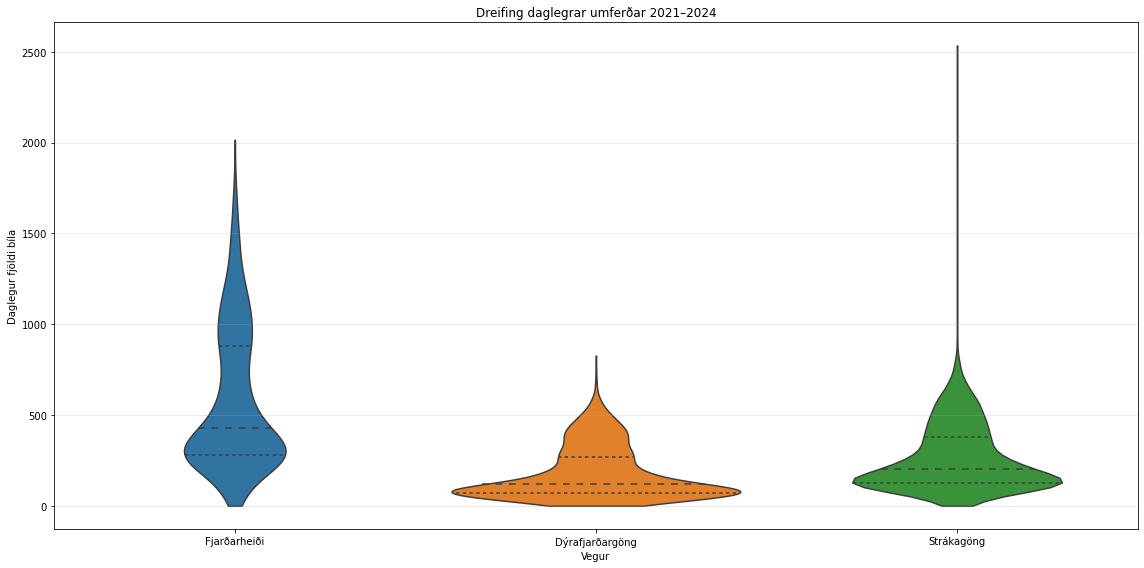

In [50]:
plt.figure(figsize=(16,8))
sns.violinplot(data=df_all.sort_values("traffic",ascending=True),x="road",y="traffic",inner="quartile",cut=0)

plt.xlabel("Vegur")
plt.ylabel("Daglegur fjöldi bíla")
plt.title("Dreifing daglegrar umferðar 2021–2024")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### 3.7 Áhrifastærð með viðmiði Cohen's (Cohen's d)

Við getum metið áhrifastærðina, þ.e. hversu mörgum staðalfrávikum umferðarmagn um `Fjarðarheiði` er frá hinum hópunum. 

| Áhrifastærð |	 d |   Skörun |
| ----------- | -- |----------- |
| Lítil       |0,20| 0,85       |
| Miðlungs    |0,50| 0,67       |
| Mikil       |0,80| 0,53       |
https://www.gba.is/cpadf/kefni/shk/s10.html

Þ.e. ef við fáum $>0.80$ úr Cohen's d prófi má meta það sem svo að áhrifin séu mikil, þ.e. dreifingar umferðamagns skarast lítið.<br>
Við erum hér einfaldlega að reyna að átta okkur á hvort er hreinn, kerfisbundinn mismunur í umferðarmagni milli veganna.

In [51]:
mean_fj = daily["Fjarðarheiði"].mean()
mean_st = daily["Strákagöng"].mean()

std_fj = daily["Fjarðarheiði"].std()
std_st = daily["Strákagöng"].std()

s_pooled = np.sqrt((std_fj**2 + std_st**2) / 2)

d_unpaired = (mean_fj - mean_st) / s_pooled

In [52]:
print(f"Fjarðarheiði-Strákagöng, d: {d_unpaired}")

Fjarðarheiði-Strákagöng, d: 1.0897456112074682


In [53]:
mean_fj = daily["Fjarðarheiði"].mean()
mean_st = daily["Dýrafjarðargöng"].mean()

std_fj = daily["Fjarðarheiði"].std()
std_st = daily["Dýrafjarðargöng"].std()

s_pooled = np.sqrt((std_fj**2 + std_st**2) / 2)

d_unpaired = (mean_fj - mean_st) / s_pooled

In [54]:
print(f"Fjarðarheiði-Dýrafjarðargöng, d: {d_unpaired}")

Fjarðarheiði-Dýrafjarðargöng, d: 1.4344239844008315


Semsagt, fyrir óparað Cohen's d próf er umferðarmagn 1.09 staðalfráviki meira um Fjarðarheiði en Strákagöng og 1.43 staðalfrávikum meiri um Fjarðarheiði en Dýrafjarðargöng.
>„Munur á daglegri umferð milli Fjarðarheiðar og Strákaganga annarsvegar og Fjarðarheiðar og Dýrafjarðarganga hinsvegar er ekki aðeins marktækur heldur einnig mjög mikill í stærðargráðu, og kemur fram á flestum dögum ársins.“

### 3.8 Dreifing mismunar á umferðarmagni

Við getum skoðað aðeins nánar hvernig dreifingin fyrir mismuninn sem við reiknuðum áður lítur út:

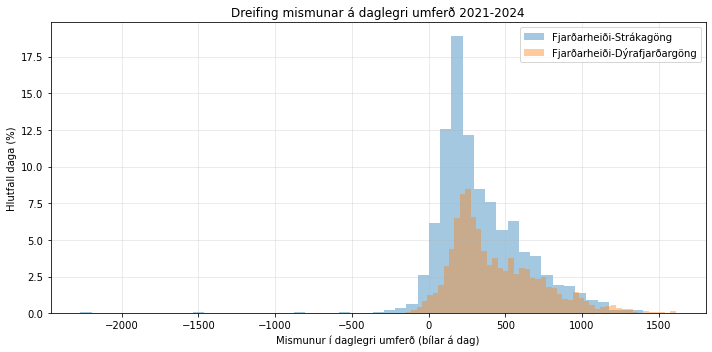

In [55]:
def percent_weights(x):
    return np.ones_like(x) / len(x) * 100

plt.figure(figsize=(10,5))

bins = 50

plt.hist(daily["dF-S"],bins=bins,weights=percent_weights(daily["dF-S"]),alpha=0.4,label="Fjarðarheiði-Strákagöng")
plt.hist(daily["dF-D"],bins=bins,weights=percent_weights(daily["dF-D"]),alpha=0.4,label="Fjarðarheiði-Dýrafjarðargöng")

plt.xlabel("Mismunur í daglegri umferð (bílar á dag)")
plt.ylabel("Hlutfall daga (%)")
plt.title("Dreifing mismunar á daglegri umferð 2021-2024")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 3.9 Wilcoxon próf
Nú spyrjum við okkur einfaldlega:

>„Er umferðin á Fjarðarheiði kerfisbundið meiri en í Dýrafjarðar- og Strákagöngum, dag fyrir dag?“ 

Við sjáum að dreifingin er bjöguð og ekki normaldreifð, notum **Wilcoxon** próf til að reikna p-gildi fyrir hvora dreifingu fyrir sig.

In [56]:
from scipy.stats import wilcoxon

stat, p = wilcoxon(daily["dF-S"])
p

2.2828271189788555e-226

In [57]:
stat, p = wilcoxon(daily["dF-D"])
p

2.1268565070138722e-237

Við fáum $p<<0.001$ svo: 
>„Á yfirgnæfandi meirihluta daga er umferð á Fjarðarheiði meiri en um Dýrafjarðar- og Strákagöng.“

### 3.10 Líkindadreifingarfall (CFD)

Skoðum líkindadreifingarfall

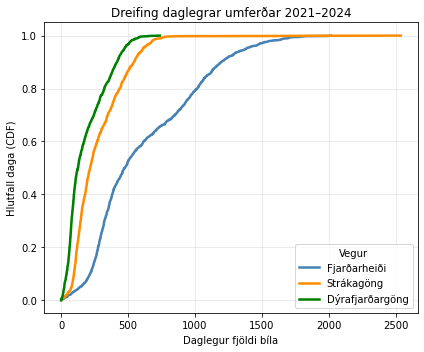

In [58]:
plt.figure(figsize=(6,5))

for road, color in zip(["Fjarðarheiði", "Strákagöng", "Dýrafjarðargöng"],["steelblue", "darkorange", "green"]):
    x = np.sort(daily[road])
    y = np.arange(1, len(x) + 1) / len(x)
    plt.plot(x, y, linewidth=2.5, label=road, color=color)

plt.xlabel("Daglegur fjöldi bíla")
plt.ylabel("Hlutfall daga (CDF)")
plt.title("Dreifing daglegrar umferðar 2021–2024")
plt.grid(True, alpha=0.3)
plt.legend(title="Vegur")
plt.tight_layout()
plt.show()

Það er sama hvar er litið, umferð um Fjarðarheiði er meiri en um Dýrafjarðar- og Strákagöng:

**Meðaltal:**<br>
$\mu_{Fjarðarheiði} > \mu_{Strákagöng}$<br>
$\mu_{Fjarðarheiði} > \mu_{Dýrafjarðargöng}$

**Miðgildi:**<br>
$\tilde{x}_{Fjarðarheiði} > \tilde{x}_{Strákagöng}$<br>
$\tilde{x}_{Fjarðarheiði} > \tilde{x}_{Dýrafjarðargöng}$<br>

**Hundraðshlutamörk:**<br>
$Q_p(Fjarðarheiði) > Q_p(Strákagöng)$<br>
$Q_p(Fjarðarheiði) > Q_p(Dýrafjarðargöng)$<br>
Fyrir næstum öll $p$ .

**Líkur á að umferð sé meiri um Fjarðarheiði en Dýrafjarðar- eða Strákagöng á degi völdum af handahófi:** <bR>
$P(Fjarðarheiði > Strákagöng) >> 0.5$<br>
$P(Fjarðarheiði > Dýrafjarðargöng) >> 0.5$

### 3.11 Fjöldi daga sem umferð er meiri um Fjarðarheiði

Skoðum svart á hvítu hversu marga daga á tímabilinu 2021-2024 umferð var meiri um Fjarðarheiði en Dýrafjarðargöng annarsvegar og Strákagöng hinsvegar.

In [59]:
n_days_total = len(daily)

n_days_f_d_more = (daily["Fjarðarheiði"] >  daily["Dýrafjarðargöng"]).sum()
n_days_f_d_draw = (daily["Fjarðarheiði"] == daily["Dýrafjarðargöng"]).sum()
n_days_f_d_less = (daily["Fjarðarheiði"] <  daily["Dýrafjarðargöng"]).sum()

percent_f_d = 100 * n_days_f_d_less / n_days_total

n_days_f_s_more = (daily["Fjarðarheiði"] >  daily["Strákagöng"]).sum()
n_days_f_s_draw = (daily["Fjarðarheiði"] == daily["Strákagöng"]).sum()
n_days_f_s_less = (daily["Fjarðarheiði"] <  daily["Strákagöng"]).sum()

percent_f_s = 100 * n_days_f_s_less / n_days_total

print(f"Yfir tímabilið 2021–2024 var meiri umferð um Dýrafjarðargöng en Fjarðarheiði "
      f"á {n_days_f_d_less} af {n_days_total} dögum "
      f"({percent_f_d:.1f}%).")

print(f"Yfir tímabilið 2021–2024 var meiri umferð um Strákagöng en Fjarðarheiði "
      f"á {n_days_f_s_less} af {n_days_total} dögum "
      f"({percent_f_s:.1f}%).")
print(f'Dagar sem jafn mikil umferð var um Dýrafjarðargöng og Fjarðarheiði: {n_days_f_d_draw}')
print(f'Dagar sem jafn mikil umferð var um Strákagöng og Fjarðarheiði: {n_days_f_s_draw}')

Yfir tímabilið 2021–2024 var meiri umferð um Dýrafjarðargöng en Fjarðarheiði á 26 af 1451 dögum (1.8%).
Yfir tímabilið 2021–2024 var meiri umferð um Strákagöng en Fjarðarheiði á 58 af 1451 dögum (4.0%).
Dagar sem jafn mikil umferð var um Dýrafjarðargöng og Fjarðarheiði: 3
Dagar sem jafn mikil umferð var um Strákagöng og Fjarðarheiði: 2


In [60]:
counts_f_d = pd.DataFrame({"Útkoma": ["Dýrafjarðargöng > Fjarðarheiði","Jafntefli","Fjarðarheiði > Dýrafjarðargöng",],
                              "Fjöldi daga": [n_days_f_d_less,n_days_f_d_draw,n_days_f_d_more,]})

counts_f_s = pd.DataFrame({"Útkoma": ["Strákagöng > Fjarðarheiði","Jafntefli","Fjarðarheiði > Strákagöng",],
                              "Fjöldi daga": [n_days_f_s_less,n_days_f_s_draw,n_days_f_s_more,]})

compare = ['Dýrafjarðargöng','Strákagöng']

counts = {}
for k,v in zip(compare, [counts_f_d,counts_f_s]):
    counts[k] = v

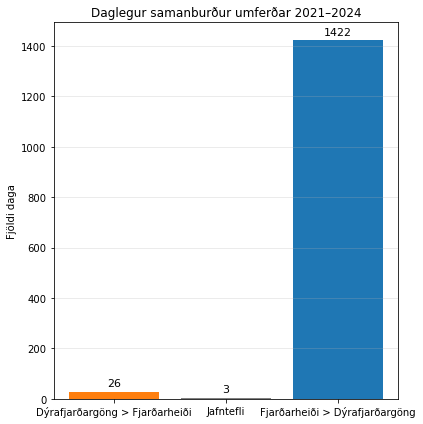

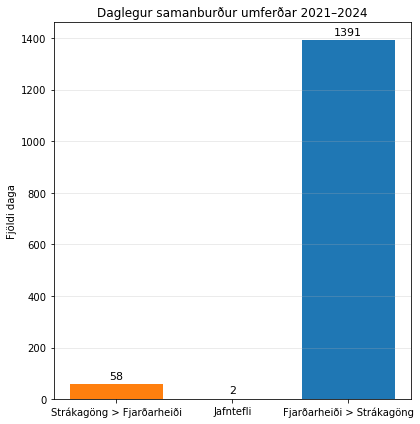

In [61]:
def plot_comparison(df):
    plt.figure(figsize=(6,6))

    plt.bar(df["Útkoma"],df["Fjöldi daga"],color=["#ff7f0e", "gray", "#1f77b4"])

    plt.ylabel("Fjöldi daga")
    plt.title("Daglegur samanburður umferðar 2021–2024")
    plt.grid(axis="y", alpha=0.3)

    for i, v in enumerate(df["Fjöldi daga"]):
        plt.text(i, v + max(df["Fjöldi daga"]) * 0.01, str(v),
                 ha="center", va="bottom", fontsize=11)

    plt.tight_layout()
    plt.show()
    
for each in counts.values():
    plot_comparison(each)

[Aftur í efnisyfirlit](#0_efnisyfirlit)
## 4. Hagkvæmnimat út frá umferðarmagni <a name="4_hagkvaemnimat"></a> 💰

Miðað við þetta afgerandi magn umferðar sem fer um Fjarðarheiði, hvað gætum við metið að göng undir Fjarðarheiði mættu kosta? <br>
Nú vill svo til að kostnaður Dýrafjarðargangna er þekktur en hann var, með vegum: 
> *Dýrafjarðargöng : 13,4 milljarðar króna með vegum*

Heimild: https://bb.is/2021/11/dyrafjardargong-134-milljardar-krona-med-vegum/

In [62]:
df_all[df_all["year"]>2020].groupby(["road"]).sum()

,traffic,year,month_num,day
road,,,,
Dýrafjarðargöng,265731.0,2954874,9530,22981
Fjarðarheiði,897782.0,2954874,9530,22981
Strákagöng,398344.0,2954874,9530,22981


In [63]:
dyrafjardargong_cost = 13_400_000_000
fh_traffic = df_all[df_all["year"]>2020].groupby(["road"]).sum().traffic["Fjarðarheiði"] 
df_traffic = df_all[df_all["year"]>2020].groupby(["road"]).sum().traffic["Dýrafjarðargöng"]
st_traffic = df_all[df_all["year"]>2020].groupby(["road"]).sum().traffic["Strákagöng"]
fh_permittable_cost = fh_traffic/df_traffic * dyrafjardargong_cost
st_permittable_cost = st_traffic/df_traffic * dyrafjardargong_cost
print(f"Fjarðarheiðargöng mega kosta: {fh_permittable_cost/1e9:.2f} ma.kr. m.v. umferðamagn og kostnað Dýrafjarðagangna")
print(f"Fljótagöng mega kosta: {st_permittable_cost/1e9:.2f} ma.kr. m.v. umferðamagn og kostnað Dýrafjarðagangna")

Fjarðarheiðargöng mega kosta: 45.27 ma.kr. m.v. umferðamagn og kostnað Dýrafjarðagangna
Fljótagöng mega kosta: 20.09 ma.kr. m.v. umferðamagn og kostnað Dýrafjarðagangna


Í skýrslu RHA um jarðgangnakosti á Mið-Austurlandi frá 2025 segir:

>*3.1 Arðsemi
Gengið út frá 13,24 km göngum með munna í 142 m h.y.s. í Eyvindarárdal á Fljótsdalshéraði en
131 m h.y.s í botni Seyðisfjarðar. Leggja þurfi 7,2 km af nýjum vegum en 3,16 km vegur fram hjá
Egilsstöðum er ekki talinn með þar sem hann er ekki nauðsynlegur til að tengja göngin. Ný brú
yfir Eyvindará verði 110 m. Heildarkostnaður án VSK verði 43.739 Mkr og framkvæmdatími
7,65 ár.*

Heimild: https://wp-beta.vegagerdin.is/wp-content/uploads/2025/12/rha-mid-austurland-jardgong_2025_a_vef.pdf

**Svo, eru Fjarðarheiðargöng e.t.v. fjárhagslega forsvaranleg?<br>**
**Út frá undangenginni jarðgangagerð virðist umferðarmagnið í það minnsta réttlæta það.**

[Aftur í efnisyfirlit](#0_efnisyfirlit)
## 5. Slysatíðni <a name="5_slysatidni"></a> 🚑

Skoðum núna tíðni umferðaslysa á hvorum vegkafla fyrir sig. <br>
Til þess höfum við `.xlsx` skrár frá Vegagerðinni.<br>
Þær má nálgast hér:
https://www.vegagerdin.is/vegagerdin/gagnasafn/skyrslur/umferdaroryggi/slysatidni/allt-landid

Við skilgreinum vegkaflana tvo, Fjarðaheiði...
![imgs/fjardarheidi_segments.png](imgs/fjardarheidi_segments.png)

... og "Strákagöng" 
![imgs/strakagong_segments.png](imgs/strakagong_segments.png)

In [64]:
# Fjarðarheiði segments
FJARDARHEIDI_SEGMENTS = [(93, 3),   # Vegnr 93, kafli 03
                         (93, 2),   # Vegnr 93, kafli 02
                        ]

# Strákagöng segments
STRAKAGONG_SEGMENTS = [(76, 9),
                       (76, 10),
                       (76, 11),]

Hlöðum svo inn slysatíðni skrá til prufu

In [65]:
def load_incident_file(path):
    df = pd.read_excel(path)
    df.columns = df.columns.str.strip().str.replace("\n", " ", regex=False)
    return df


In [66]:
df_2018 = load_incident_file(datapath+"slysatidni_2018-1.xlsx")
df_2018.head()

,Vegnr,Kaflanr,Vegheiti,Heiti upphafspunkts,Heiti endapunkts,Lengd,ÁDU,Eigna- tjón,Lítil meiðsl,Mikil meiðsl,Bana- slys,Samtals,Slysa- tíðni,Eknir þús. km
0,1,a1,Hringvegur,"Sýslumörk, sýslusteinn",Núpsstaður,9.01,1344.0,5.0,0.0,1.0,1.0,7.0,1.583730,4419.946
1,1,a2,Hringvegur,Núpsstaður,Dalshöfðavegur (2019-01),11.13,1474.0,2.0,1.0,0.0,0.0,3.0,0.500998,5988.051
2,1,a3,Hringvegur,Dalshöfðavegur (2019-01),Foss,9.44,1546.0,1.0,0.0,0.0,0.0,1.0,0.187727,5326.898
3,1,a4,Hringvegur,Foss,Klausturvegur (205-01),11.41,1688.0,3.0,1.0,1.0,0.0,5.0,0.711271,7029.666
4,1,a6,Hringvegur,Klausturvegur (205-01),Skál,13.14,1679.0,3.0,0.0,0.0,0.0,3.0,0.372648,8050.494


Síum fyrir þessa vegkafla

In [67]:
def filter_segments(df, segments):
    df = df.copy()

    df["Vegnr_num"] = pd.to_numeric(df["Vegnr"], errors="coerce")
    df["Kaflanr_num"] = pd.to_numeric(df["Kaflanr"], errors="coerce")

    # drop rows where either is not numeric
    df = df.dropna(subset=["Vegnr_num", "Kaflanr_num"])

    # convert to int AFTER cleaning
    df["Vegnr_num"] = df["Vegnr_num"].astype(int)
    df["Kaflanr_num"] = df["Kaflanr_num"].astype(int)

    # build a set for fast lookup
    segment_set = set(segments)

    mask = list(
        zip(df["Vegnr_num"], df["Kaflanr_num"])
    )

    return df[[pair in segment_set for pair in mask]]

In [68]:
fj_2018 = filter_segments(df_2018, FJARDARHEIDI_SEGMENTS)
st_2018 = filter_segments(df_2018, STRAKAGONG_SEGMENTS)

Kíkjum á afraksturinn

In [69]:
fj_2018

,Vegnr,Kaflanr,Vegheiti,Heiti upphafspunkts,Heiti endapunkts,Lengd,ÁDU,Eigna- tjón,Lítil meiðsl,Mikil meiðsl,Bana- slys,Samtals,Slysa- tíðni,Eknir þús. km,Vegnr_num,Kaflanr_num
764,93,2,Seyðisfjarðarvegur,Borgarfjarðarvegur (94-01),"Sýslumörk, Gagnheiðarvegur",9.91,603.0,1.0,1.0,0.0,0.0,2.0,0.916410,2182.430,93,2
765,93,3,Seyðisfjarðarvegur,"Sýslumörk, Gagnheiðarvegur","Seyðisfjörður, kirkjugarðshorn",14.04,640.0,1.0,3.0,0.0,0.0,4.0,1.218761,3282.022,93,3


In [70]:
st_2018

,Vegnr,Kaflanr,Vegheiti,Heiti upphafspunkts,Heiti endapunkts,Lengd,ÁDU,Eigna- tjón,Lítil meiðsl,Mikil meiðsl,Bana- slys,Samtals,Slysa- tíðni,Eknir þús. km,Vegnr_num,Kaflanr_num
654,76,9,Siglufjarðarvegur,Ólafsfjarðarvegur (82-12),"Almenningsnöf, skýli ytra horn",13.47,300.0,2.0,0.0,1.0,0.0,3.0,2.036788,1472.907,76,9
655,76,10,Siglufjarðarvegur,"Almenningsnöf, skýli ytra horn",Gangamunni eystri,8.00,330.0,1.0,0.0,0.0,0.0,1.0,1.037775,963.600,76,10
656,76,11,Siglufjarðarvegur,Gangamunni eystri,"Siglufjörður, Hólavegur",2.20,486.0,1.0,0.0,0.0,0.0,1.0,2.562407,390.258,76,11


Tökum nú saman þetta 6-ára tímabil

In [71]:
def aggregate_year(df, year, road_name, count_col="Samtals"):
    return pd.DataFrame({
        "year": [year],
        "road": [road_name],
        "incidents": [pd.to_numeric(df[count_col], errors="coerce").sum()]
    })

In [72]:
FILES = {
    2018: datapath + "slysatidni_2018-1.xlsx",
    2019: datapath + "slysatidni_2019.xlsx",
    2020: datapath +  "slysatidni_2020-2.xlsx",
    2021: datapath +  "slysatidni_2021-18.xlsx",
    2022: datapath +  "slysatidni_2022.xlsx",
    2023: datapath +  "slysatidni_2023.xlsx",
    2024: datapath +  "slysatidni_2024_hbsv.xlsx",
}


In [73]:
SEVERITY_COLS = {
    "Eigna- tjón": "Eignatjón",
    "Lítil meiðsl": "Lítil meiðsl",
    "Mikil meiðsl": "Mikil meiðsl",
    "Bana- slys": "Banaslys",
}

In [74]:
def aggregate_year_by_severity(df, year, road_name):
    out = {
        "year": year,
        "road": road_name,
    }

    for col, label in SEVERITY_COLS.items():
        out[label] = pd.to_numeric(df[col], errors="coerce").sum()

    return pd.DataFrame([out])

In [75]:
rows = []

for year, path in FILES.items():
    df = load_incident_file(path)

    fj = filter_segments(df, FJARDARHEIDI_SEGMENTS)
    st = filter_segments(df, STRAKAGONG_SEGMENTS)

    rows.append(aggregate_year_by_severity(fj, year, "Fjarðarheiði"))
    rows.append(aggregate_year_by_severity(st, year, "Strákagöng"))

df_severity = pd.concat(rows, ignore_index=True)
df_severity

,year,road,Eignatjón,Lítil meiðsl,Mikil meiðsl,Banaslys
0,2018,Fjarðarheiði,2.0,4.0,0.0,0.0
1,2018,Strákagöng,4.0,0.0,1.0,0.0
2,2019,Fjarðarheiði,3.0,1.0,0.0,0.0
3,2019,Strákagöng,1.0,1.0,0.0,0.0
4,2020,Fjarðarheiði,1.0,2.0,0.0,0.0
5,2020,Strákagöng,1.0,1.0,0.0,0.0
6,2021,Fjarðarheiði,2.0,1.0,1.0,0.0
7,2021,Strákagöng,8.0,1.0,0.0,0.0
8,2022,Fjarðarheiði,5.0,1.0,1.0,0.0
9,2022,Strákagöng,1.0,2.0,0.0,0.0


In [76]:
df_sev_long = df_severity.melt(
    id_vars=["year", "road"],
    var_name="severity",
    value_name="incidents"
)

In [77]:
from matplotlib.patches import Patch

def plot_severity_grouped_by_year(
    df_sev_long,
    roads=("Fjarðarheiði", "Strákagöng"),
    severity_order=("Eignatjón", "Lítil meiðsl", "Mikil meiðsl", "Banaslys"),
    title="Slys eftir alvarleika 2018–2024"
):
    years = sorted(df_sev_long["year"].unique())

    dfp = df_sev_long.copy()
    dfp["severity"] = pd.Categorical(dfp["severity"], categories=severity_order, ordered=True)

    wide = (
        dfp.groupby(["year", "road", "severity"], as_index=False)["incidents"].sum()
           .pivot_table(index=["year", "road"], columns="severity", values="incidents", fill_value=0)
           .reindex(pd.MultiIndex.from_product([years, roads], names=["year","road"]))
           .fillna(0)
    )

    palette = sns.color_palette(n_colors=len(severity_order))
    color_map = dict(zip(severity_order, palette))

    x = np.arange(len(years))
    width = 0.35
    offsets = {roads[0]: -width/2, roads[1]: +width/2}

    fig, ax = plt.subplots(figsize=(13,5))

    for road in roads:
        bottoms = np.zeros(len(years))

        for sev in severity_order:
            vals = np.array([wide.loc[(y, road), sev] for y in years])

            ax.bar(
                x + offsets[road],
                vals,
                width=width,
                bottom=bottoms,
                color=color_map[sev],
                edgecolor="black",
                linewidth=0.3,
                hatch="//" if road == roads[1] else None,
                label=sev if road == roads[0] else None
            )
            bottoms += vals

    ax.set_xticks(x)
    ax.set_xticklabels(years, rotation=0)

    ax.set_xlabel("Ár")
    ax.set_ylabel("Fjöldi slysa")
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.3)

    # Legends
    severity_legend = ax.legend(
        title="Alvarleiki",
        bbox_to_anchor=(1.02, 1),
        loc="upper left"
    )

    road_legend = [
        Patch(facecolor="white", edgecolor="black", label="Fjarðarheiði"),
        Patch(facecolor="white", edgecolor="black", hatch="//", label="Strákagöng"),
    ]

    ax.add_artist(severity_legend)
    ax.legend(
        handles=road_legend,
        title="Vegur",
        bbox_to_anchor=(1.02, 0.55),
        loc="upper left"
    )

    plt.tight_layout()
    plt.show()


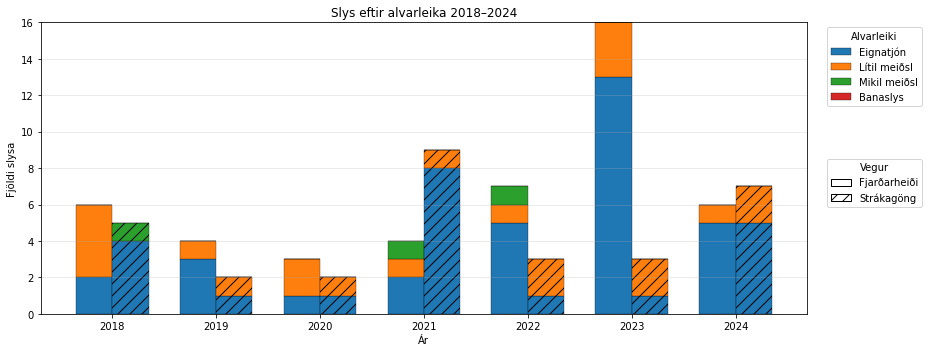

In [78]:
plot_severity_grouped_by_year(df_sev_long)

In [79]:
total_6y = (
    df_sev_long
    .groupby(["road", "severity"])["incidents"]
    .sum()
    .reset_index()
)

total_6y

,road,severity,incidents
0,Fjarðarheiði,Banaslys,0.0
1,Fjarðarheiði,Eignatjón,31.0
2,Fjarðarheiði,Lítil meiðsl,13.0
3,Fjarðarheiði,Mikil meiðsl,2.0
4,Strákagöng,Banaslys,0.0
5,Strákagöng,Eignatjón,21.0
6,Strákagöng,Lítil meiðsl,9.0
7,Strákagöng,Mikil meiðsl,1.0


In [80]:
SEVERITY_COLORS = {
    "Eignatjón": "#1f77b4",    # blue
    "Lítil meiðsl": "#ff7f0e", # orange
    "Mikil meiðsl": "#2ca02c", # green
    "Banaslys": "#d62728",    # red
}

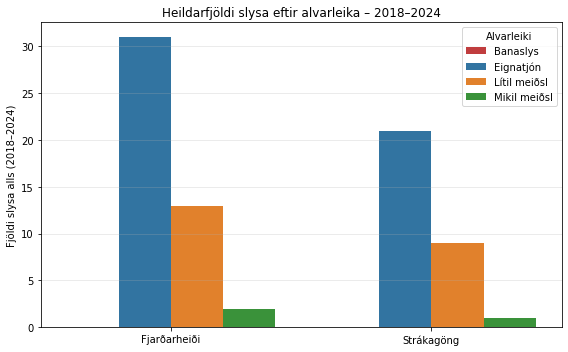

In [81]:
plt.figure(figsize=(8,5))

sns.barplot(
    data=total_6y,
    x="road",
    y="incidents",
    hue="severity",
    palette=SEVERITY_COLORS
)

plt.xlabel("")
plt.ylabel("Fjöldi slysa alls (2018–2024)")
plt.title("Heildarfjöldi slysa eftir alvarleika – 2018–2024")
plt.legend(title='Alvarleiki')
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

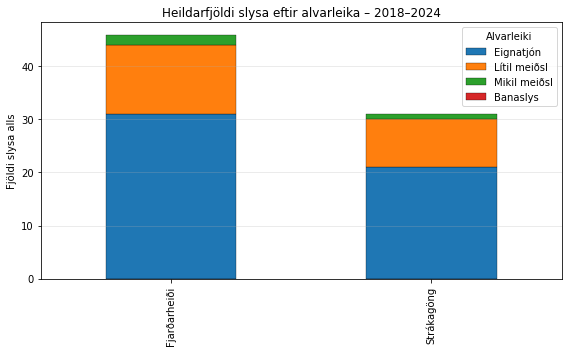

In [82]:
wide_total = (
    total_6y
    .pivot(index="road", columns="severity", values="incidents")
    .fillna(0)
)

wide_total = wide_total[list(SEVERITY_COLORS.keys())]  # enforce order

wide_total.plot(
    kind="bar",
    stacked=True,
    figsize=(8,5),
    color=[SEVERITY_COLORS[c] for c in wide_total.columns],
    edgecolor="black",
    linewidth=0.3
)

plt.ylabel("Fjöldi slysa alls")
plt.title("Heildarfjöldi slysa eftir alvarleika – 2018–2024")
plt.grid(axis="y", alpha=0.3)
plt.xlabel('')
plt.legend(title='Alvarleiki')
plt.tight_layout()
plt.show()

[Aftur í efnisyfirlit](#0_efnisyfirlit)